In [4]:
import parse_data.prepare_data as prepare_data
import parse_data.flip_rotate_trajectories as flip_rotate_trajectories
from analysis.response_times import calculate_response_times, plot_response_times
import data_extraction.get_indices as get_indices
import globals
from plotting import plot_octagon, plot_trajectory
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Polygon
from matplotlib import colors
import math

In [5]:
# paths
# data_folder = '/home/tom/Documents/SWC/data' # desktop Duan Lab
# json_filename = '240913_Yansu_Jerry/2024-09-13_11-53-34_YansuSecondSolo.json' 
# json_filename = '240913_Yansu_Jerry/2024-09-13_11-31-00_YansuJerrySocial.json'
data_folder = r'D:\Users\Tom\OneDrive\PhD\SWC\data' # desktop home
data_folder = r'C:\Users\tomha\OneDrive\PhD\SWC\data' # octagon laptop
# json_filename = r'first_experiments_2409\240913\2024-09-13_11-23-37_YansuFirstSolo.json'
# json_filenames = [r'first_experiments_2409\240913\2024-09-13_11-31-00_YansuJerrySocial.json']
# all socials
json_filenames = [r'first_experiments_2409\240913\2024-09-13_11-31-00_YansuJerrySocial.json',
                   r'second_experiments_2409\240927\2024-09-27_14-25-20_SaraEmilySocial.json',
                   r'third_experiments_2410\241017\2024-10-17_14-28-40_ShamirAbigailSocial.json',
                   r'fourth_experiments_2410\241017\2024-10-17_16-41-38_ZimoElsaSocial.json']

In [6]:
# prepare the session dataframe and dataframes of each individual trial
df, trial_list = prepare_data.prepare_data(data_folder, json_filenames)

Data is from period before 2024-09-13 00:00:00
Running dataframe through playerinfo_playerposition_conversion.
Loading complete.
Loading complete.
Loading complete.
Loading complete.
Preprocessing complete.
Preprocessing complete.
Preprocessing complete.
Preprocessing complete.


In [7]:
## HEATMAPS ##

In [8]:
x_min = -20
x_max = 20
y_min = -20
y_max = 20

In [9]:
def heatmap_counts_from_location_data(location_array, n_rows=6, n_cols=6, x_min=x_min, x_max=x_max, 
                                      y_min=y_min, y_max=y_max):
    ''' Produce a matrix of counts across spatial location from n-x-2 location data '''

    # define a grid of counts
    grid_width = (x_max - x_min)/n_cols
    grid_height = (y_max - y_min)/n_rows
    grid = np.zeros([n_rows, n_cols])

    # Create a matrix of heatmap counts based on which bin starting location fits into
    for i in range(len(location_array[:,0])):
        x_val = location_array[i,0]
        y_val = location_array[i,1]
        x_bin = int((x_val - x_min)/grid_width)
        y_bin = int((y_val - y_min)/grid_height)

        if 0 <= y_bin < n_rows and 0 <= x_bin < n_cols:
            grid[y_bin, x_bin] += 1

    return grid

In [10]:
def plot_heatmap_from_count_array(ax, count_array, x_min=x_min, x_max=x_max, 
                                      y_min=y_min, y_max=y_max, vmin=None, vmax=None):

    # get the zipped coordinate list of octagon x and y vertex points
    octagon_vertex_coordinates = plot_octagon.return_octagon_path_points()

    if vmin is None:
        # display heatmap, covering the full graph
        im = ax.imshow(count_array, extent=[x_min, x_max, y_min, y_max],
                   origin='lower', cmap='viridis')

    else:
        # display heatmap, covering the full graph
        im = ax.imshow(count_array, extent=[x_min, x_max, y_min, y_max],
                   origin='lower', cmap='viridis', vmin=0, vmax=1)  
    
    # a matplotlib Artist with an edge and face colour
    patch = Polygon(octagon_vertex_coordinates, edgecolor='black', facecolor='none', lw=2)
    

    ax.add_patch(patch)         # make octagon outline visible
    im.set_clip_path(patch)     # crop image to coordinates inside the outline
    
    # Set aspect ratio to be square
    ax.set_aspect(1.)
    
    plt.colorbar(im)

    ax.set_title("Count heatmap of winner location at the start of each trial")
    
    # give some white border to the graph
    ax.set_xlim([-22,22])
    ax.set_ylim([-22,22])

    return ax

In [11]:
def winner_start_loc_heatmap(trial_list, wall_sep=1, high_low_only=True, chose_high_only=True):
    ''' Plot a heatmap of the winner's location in the arena when the walls are
        revealed. This is done for all trials with a given wall separation, and 
        flipped and rotated to put the High wall at 0 degrees and the Low wall at 45 
        degrees '''
    
    # filter trials for a wall separation of wall_sep
    trial_indices = get_indices.get_trials_with_wall_sep(trial_list, wall_sep=wall_sep) # verified correct indices
    
    # further filter by HighLow trial type if specified
    if high_low_only:
        high_low_trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=globals.HIGH_LOW)
        trial_indices = np.intersect1d(trial_indices, high_low_trial_indices)

    # further filter by chose High if specified
    if chose_high_only:
        chose_high_trial_indices = get_indices.get_trials_chose_high(trial_list)
        trial_indices = np.intersect1d(trial_indices, chose_high_trial_indices)
        
    trial_list_filtered = [trial_list[i] for i in trial_indices] # just list comp
    
    # flip and rotate the relevant trials for High and Low to be walls 1 and 2
    flip_rotated_trials = []
    for i in range(len(trial_list_filtered)):
        flip_rotated_trials.append(flip_rotate_trajectories.flip_rotate_trajectories(trial_list_filtered, trial_index=i)) 
    
    # get the ID of the player who ended the trial, for each trial
    trigger_activators_slice_onset_loc = get_indices.get_trigger_activators_slice_onset_loc(flip_rotated_trials)
    trigger_activators_slice_onset_loc = np.asarray(trigger_activators_slice_onset_loc)
    
    # generate heat map data and plot
    count_array = heatmap_counts_from_location_data(trigger_activators_slice_onset_loc)
    ax = plot_octagon.plot_octagon()
    plot_heatmap_from_count_array(ax, count_array)

    return ax

In [12]:
def probability_choose_high_heatmap(trial_list, wall_sep=1, high_low_only=True, chose_high=True):
    ''' Plot a heatmap of probability of choosing High against slice onset location
        over all of Octagon space '''

    # filter trials for a wall separation of wall_sep
    trial_indices = get_indices.get_trials_with_wall_sep(trial_list, wall_sep=wall_sep) # verified correct indices
    
    # further filter by HighLow trial type if specified
    if high_low_only:
        high_low_trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=globals.HIGH_LOW)
        trial_indices = np.intersect1d(trial_indices, high_low_trial_indices)
    
    # further filter by chose High if specified
    if chose_high:
        chose_high_trial_indices = get_indices.get_trials_chose_high(trial_list)
        chose_high_trial_indices = np.intersect1d(trial_indices, chose_high_trial_indices)

    trial_list_filtered = [trial_list[i] for i in trial_indices] # just list comp
    trial_list_filtered_chose_high = [trial_list[i] for i in chose_high_trial_indices] 
    
    # flip and rotate the relevant trials for High and Low to be walls 1 and 2
    flip_rotated_trials = []
    for i in range(len(trial_list_filtered)):
        flip_rotated_trials.append(flip_rotate_trajectories.flip_rotate_trajectories(trial_list_filtered, trial_index=i)) 

    flip_rotated_trials_chose_high = []
    for i in range(len(trial_list_filtered_chose_high)):
        flip_rotated_trials_chose_high.append(flip_rotate_trajectories.flip_rotate_trajectories(trial_list_filtered_chose_high, trial_index=i)) 
    
    # get the ID of the player who ended the trial, for each trial
    trigger_activators_slice_onset_loc = get_indices.get_trigger_activators_slice_onset_loc(flip_rotated_trials)
    trigger_activators_slice_onset_loc = np.asarray(trigger_activators_slice_onset_loc)

    trigger_activators_slice_onset_loc_chose_high = get_indices.get_trigger_activators_slice_onset_loc(flip_rotated_trials_chose_high)
    trigger_activators_slice_onset_loc_chose_high = np.asarray(trigger_activators_slice_onset_loc_chose_high)

    # get counts by location for all trials and for winner-chose-high trials
    count_array = heatmap_counts_from_location_data(trigger_activators_slice_onset_loc, n_rows=9, n_cols=9)
    count_array_chose_high = heatmap_counts_from_location_data(trigger_activators_slice_onset_loc_chose_high, n_rows=9, n_cols=9)

    print("total trial counts by location":, count_array)
    print("chose high counts by location:", count_array_chose_high)

    # element-wise division, avoiding division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        probability_count_array = np.divide(count_array_chose_high, count_array)
        probability_count_array[count_array == 0] = np.nan  # Set divisions by zero to NaN

    # remove bins with too few trials
    probability_count_array[count_array < 4] = np.nan  
    
    ax = plot_octagon.plot_octagon()
    plot_heatmap_from_count_array(ax, probability_count_array, vmin=0, vmax=1)

    return ax

Text(0.5, 1.0, 'Count heatmap of winner location at the start of each trial,\n for 45 degree wall separation')

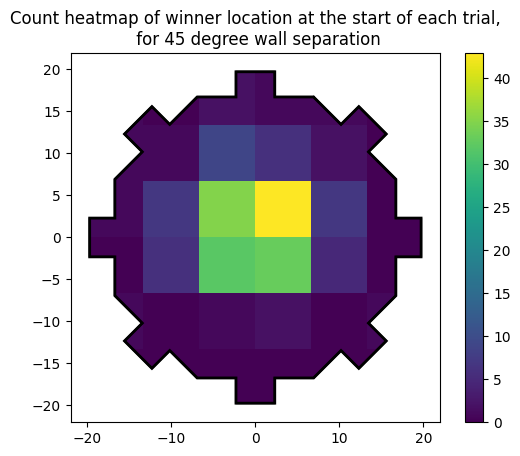

In [13]:
ax = winner_start_loc_heatmap(trial_list, wall_sep=1, high_low_only=False, chose_high_only=False)
ax.set_title("Count heatmap of winner location at the start of each trial,\n for 45 degree wall separation")

Text(0.5, 1.0, 'Count heatmap of winner location at the start of each trial,\n for 90 degree wall separation')

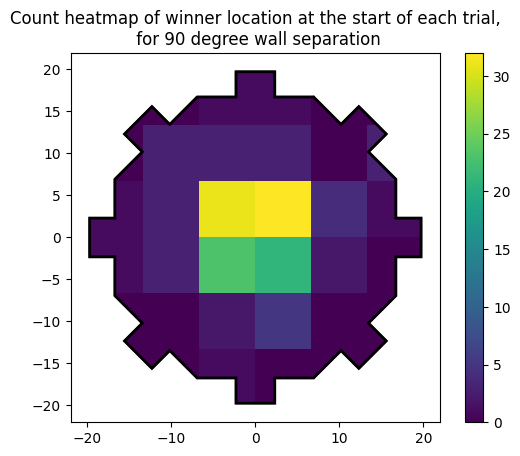

In [14]:
ax = winner_start_loc_heatmap(trial_list, wall_sep=2, high_low_only=False, chose_high_only=False)
ax.set_title("Count heatmap of winner location at the start of each trial,\n for 90 degree wall separation")

Text(0.5, 1.0, 'Count heatmap of winner location at the start of each trial,\n for 180 degree wall separation')

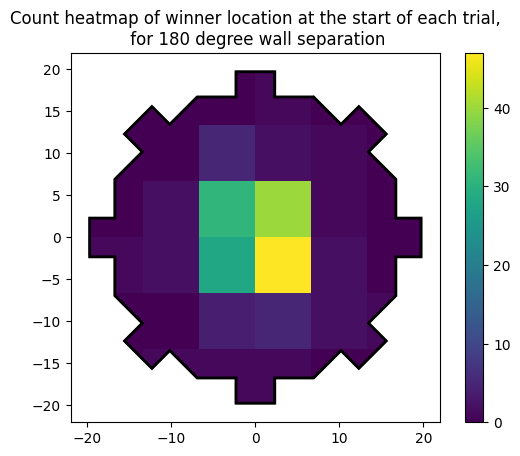

In [15]:
ax = winner_start_loc_heatmap(trial_list, wall_sep=4, high_low_only=False, chose_high_only=False)
ax.set_title("Count heatmap of winner location at the start of each trial,\n for 180 degree wall separation")

Text(0.5, 1.0, 'Count heatmap of winner location at the start of each trial,\n for 45 degree wall separation, HighLow trials, and Choose High')

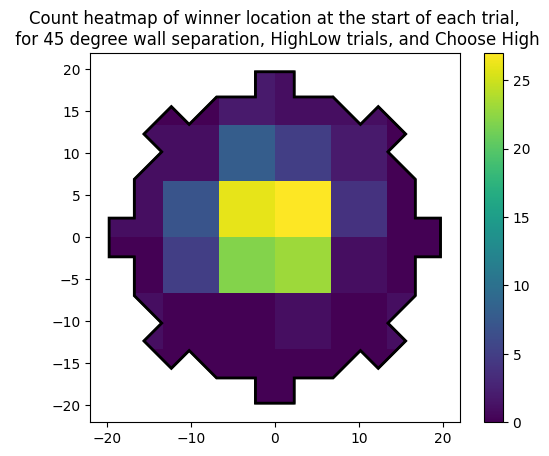

In [16]:
ax = winner_start_loc_heatmap(trial_list, wall_sep=1, high_low_only=True, chose_high_only=True)
ax.set_title("Count heatmap of winner location at the start of each trial,\n for 45 degree wall separation, HighLow trials, and Choose High")

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  1.  0.  0.  0.  1.]
 [ 0.  2.  1.  5. 10.  4.  1.  1.  0.]
 [ 0.  1.  4. 11. 41. 17.  1.  2.  0.]
 [ 0.  2.  3.  8.  9. 10.  4.  0.  0.]
 [ 0.  0.  1.  6.  4.  5.  1.  0.  0.]
 [ 0.  1.  0.  1.  0.  0.  2.  0.  0.]
 [ 0.  0.  0.  0.  2.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  1.  0.  0.  0.  1.]
 [ 0.  2.  1.  4.  9.  3.  0.  0.  0.]
 [ 0.  1.  4.  9. 38. 13.  1.  1.  0.]
 [ 0.  2.  3.  8.  7.  7.  3.  0.  0.]
 [ 0.  0.  1.  5.  4.  4.  1.  0.  0.]
 [ 0.  1.  0.  1.  0.  0.  2.  0.  0.]
 [ 0.  0.  0.  0.  2.  0.  0.  0.  0.]]


Text(0.5, 1.0, 'Probability heatmap of choose High across locations at the start of each trial,\n for 45 degree wall separation, HighLow trials')

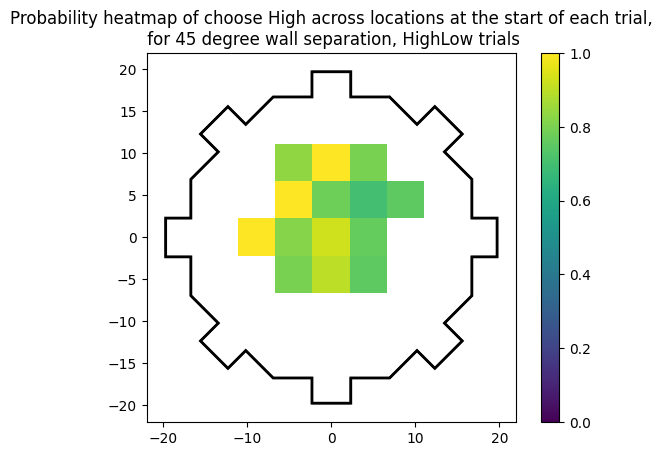

In [17]:
ax = probability_choose_high_heatmap(trial_list, wall_sep=1, high_low_only=True)
ax.set_title("Probability heatmap of choose High across locations at the start of each trial,\n for 45 degree wall separation, HighLow trials")